In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

def adj_r2_score(r2, n, k):
    return 1-((1-r2)*((n-1)/(n-k-1)))

In [6]:
future_data = pd.read_csv('Soy_Bean_Indore.csv')
future_data["Date"] = pd.to_datetime(future_data["Date"])
ind_data = future_data.set_index(["Date","Time"], drop=True)
ind_data.head()

Price
Date       Time           
2018-03-28 12:06:00   3776
           15:13:00   3779
2018-03-27 12:14:00   3778
           15:12:00   3777
2018-03-26 12:07:00   3783

### Real DataFrame

In [3]:
ind_data.head()

Price
Date       Time           
2018-03-28 12:06:00   3776
           15:13:00   3779
2018-03-27 12:14:00   3778
           15:12:00   3777
2018-03-26 12:07:00   3783

### Reversed and Flipped DataFrame

In [4]:
data_frame = ind_data.sort_index(axis=1 ,ascending=True)
data_frame = data_frame.iloc[::-1]
data_frame.head()

Price
Date       Time           
2008-05-02 15:35:00   2192
           12:02:00   2186
2008-05-03 12:02:00   2204
2008-05-05 15:33:00   2205
           12:02:00   2199

In [5]:
df = data_frame[["Price"]]

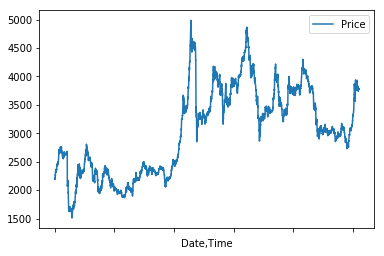

In [6]:
df.plot()

In [7]:
n = ind_data.shape[0]
p = ind_data.shape[1]

In [8]:
split = int(np.floor(0.8*n))
d_cpy=data_frame.copy()
train = d_cpy[:split]
test = d_cpy[split:]


'train.head()\ntest.head()\ntrain.tail()'

In [10]:
sc = MinMaxScaler()
train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

/home/aakanksha/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


# SVM

In [11]:
X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

In [12]:
from sklearn.svm import SVR
regressor = SVR(kernel='rbf')

In [13]:
regressor.fit(X_train, y_train)
y_pred_svr = regressor.predict(X_test)

/home/aakanksha/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/aakanksha/miniconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [14]:

print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_svr)))
r2_test = r2_score(y_test, y_pred_svr)
print("The Adjusted R2 score on the Test set is:\t{:0.3f}".format(adj_r2_score(r2_test, X_test.shape[0], X_test.shape[1])))

The R2 score on the Test set is:	0.767
The Adjusted R2 score on the Test set is:	0.767


# Non-Shifted

## ANN

In [16]:
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import load_model

Using TensorFlow backend.


In [17]:
K.clear_session()

model = Sequential()
model.add(Dense(12, input_dim=1, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
history = model.fit(X_train, y_train, epochs=200, batch_size=1, verbose=1, callbacks=[early_stop], shuffle=False)

Epoch 1/200
4079/4079 [==============================] - 58s 14ms/step - loss: 1.1758e-04
Epoch 2/200
4079/4079 [==============================] - 35s 9ms/step - loss: 1.3620e-04
Epoch 3/200
4079/4079 [==============================] - 34s 8ms/step - loss: 1.5293e-04
Epoch 00003: early stopping


In [18]:
y_pred_test_ann = model.predict(X_test)
y_train_pred_ann = model.predict(X_train)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_ann)))
r2_train = r2_score(y_train, y_train_pred_ann)
print("The Adjusted R2 score on the Train set is:\t{:0.3f}\n".format(adj_r2_score(r2_train, X_train.shape[0], X_train.shape[1])))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_ann)))
r2_test = r2_score(y_test, y_pred_test_ann)
print("The Adjusted R2 score on the Test set is:\t{:0.3f}".format(adj_r2_score(r2_test, X_test.shape[0], X_test.shape[1])))

The R2 score on the Train set is:	0.792
The Adjusted R2 score on the Train set is:	0.792

The R2 score on the Test set is:	0.761
The Adjusted R2 score on the Test set is:	0.761


In [19]:
model.save('ANN_NonShift.h5')

### Process the data for LSTM

In [20]:
X_tr_t = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_tst_t = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

## LSTM

In [21]:
from keras.layers import LSTM
K.clear_session()
model_lstm = Sequential()
model_lstm.add(LSTM(7, input_shape=(1, X_train.shape[1]), activation='relu', kernel_initializer='lecun_uniform', return_sequences=False))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history_model_lstm = model_lstm.fit(X_tr_t, y_train, epochs=200, batch_size=1, verbose=1, shuffle=False, callbacks=[early_stop])

y_pred_test_lstm = model_lstm.predict(X_tst_t)
y_train_pred_lstm = model_lstm.predict(X_tr_t)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_lstm)))
r2_train = r2_score(y_train, y_train_pred_lstm)
print("The Adjusted R2 score on the Train set is:\t{:0.3f}\n".format(adj_r2_score(r2_train, X_train.shape[0], X_train.shape[1])))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_lstm)))
r2_test = r2_score(y_test, y_pred_test_lstm)
print("The Adjusted R2 score on the Test set is:\t{:0.3f}".format(adj_r2_score(r2_test, X_test.shape[0], X_test.shape[1])))

Epoch 1/200
4079/4079 [==============================] - 128s 31ms/step - loss: 0.0052
Epoch 2/200
4079/4079 [==============================] - 91s 22ms/step - loss: 4.8305e-04
Epoch 3/200
4079/4079 [==============================] - 75s 18ms/step - loss: 2.1194e-04
Epoch 4/200
4079/4079 [==============================] - 91s 22ms/step - loss: 1.7218e-04
Epoch 5/200
4079/4079 [==============================] - 82s 20ms/step - loss: 1.5971e-04
Epoch 6/200
4079/4079 [==============================] - 120s 29ms/step - loss: 1.5589e-04
Epoch 7/200
4079/4079 [==============================] - 113s 28ms/step - loss: 1.5431e-04
Epoch 8/200
4079/4079 [==============================] - 118s 29ms/step - loss: 1.5373e-04
Epoch 9/200
4079/4079 [==============================] - 123s 30ms/step - loss: 1.5341e-04
Epoch 10/200
4079/4079 [==============================] - 118s 29ms/step - loss: 1.5374e-04
Epoch 11/200
4079/4079 [==============================] - 124s 30ms/step - loss: 1.5380e-04
Epoch

In [22]:
model_lstm.save('LSTM_NonShift.h5')

## Predictions made by each Model

In [23]:
model_ann = load_model('ANN_NonShift.h5')
model_lstm = load_model('LSTM_NonShift.h5')

In [24]:
score_ann= model_ann.evaluate(X_test, y_test, batch_size=1)
score_lstm= model_lstm.evaluate(X_tst_t, y_test, batch_size=1)

1020/1020 [==============================] - 13s 12ms/step


In [26]:
print('ANN: %f'%score_ann)
print('LSTM: %f'%score_lstm)

ANN: 0.018102
LSTM: 0.002390


In [27]:
y_pred_test_ANN = model_ann.predict(X_test)
y_pred_test_LSTM = model_lstm.predict(X_tst_t)

In [28]:
col1 = pd.DataFrame(y_test, columns=['True'])
col2 = pd.DataFrame(y_pred_test_ANN, columns=['ANN_prediction'])
col3 = pd.DataFrame(y_pred_test_LSTM, columns=['LSTM_prediction'])
col4 = pd.DataFrame(history.history['loss'], columns=['Loss_ANN'])
col5 = pd.DataFrame(history_model_lstm.history['loss'], columns=['Loss_LSTM'])
results = pd.concat([col1, col2, col3, col4, col5], axis=1)
results.to_csv('PredictionResults_ANN-LSTM_NonShift.csv')

## SVM

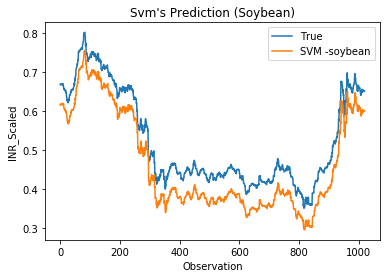

In [31]:
plt.plot(y_test, label='True')
plt.plot(y_pred_svr, label='SVM -soybean')
plt.title("Svm's Prediction (Soybean)")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()

### ANN's Prediction Visual

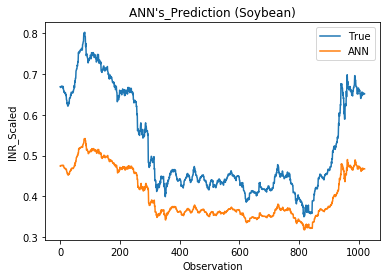

In [32]:
plt.plot(y_test, label='True')
plt.plot(y_pred_test_ANN, label='ANN')
plt.title("ANN's_Prediction (Soybean)")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()

### LSTM's Prediction Visual

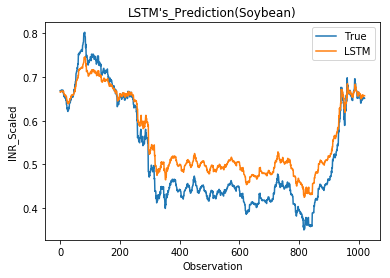

In [33]:
plt.plot(y_test, label='True')
plt.plot(y_pred_test_LSTM, label='LSTM')
plt.title("LSTM's_Prediction(Soybean)")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()